In [1]:
#@test {"skip": true}

# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

!pip install -q tensorflow_federated

^C
Operation cancelled by user
You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import absolute_import, division, print_function


import collections
from six.moves import range
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.optimizer_v2 import gradient_descent
from tensorflow_federated import python as tff

nest = tf.contrib.framework.nest

np.random.seed(0)

tf.compat.v1.enable_v2_behavior()

tff.federated_computation(lambda: 'Its, Working!')()

'Its, Working!'

In [3]:
#@test {"output": "ignore"}
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

97402880/97398400 [==============================] - 76s 1us/step


In [4]:
len(emnist_train.client_ids)

3383

In [5]:
emnist_train.output_types, emnist_train.output_shapes

(OrderedDict([('label', tf.int32), ('pixels', tf.float32)]),
 OrderedDict([('label', TensorShape([])), ('pixels', TensorShape([28, 28]))]))

In [6]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = iter(example_dataset).next()

example_element['label'].numpy()

Instructions for updating:
Colocations handled automatically by placer.


5

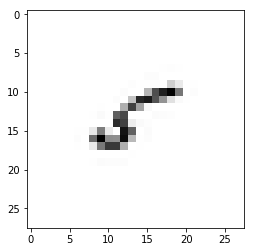

In [10]:
#@test {"output": "ignore"}
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid('off')
_ = plt.show()

In [11]:
NUM_EPOCHS = 10
BATCH_SIZE = 20
SHUFFLE_BUFFER = 500


def preprocess(dataset):

  def element_fn(element):
    return collections.OrderedDict([
        ('x', tf.reshape(element['pixels'], [-1])),
        ('y', tf.reshape(element['label'], [1])),
    ])

  return dataset.repeat(NUM_EPOCHS).map(element_fn).shuffle(
      SHUFFLE_BUFFER).batch(BATCH_SIZE)

In [12]:
#@test {"output": "ignore"}
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = nest.map_structure(
    lambda x: x.numpy(), iter(preprocessed_example_dataset).next())

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[0],
                     [4],
                     [2],
                     [1],
                     [9],
                     [0],
                     [3],
                     [0],
                     [7],
                     [2],
                     [1],
                     [8],
                     [2],
                     [5],
                     [6],
                     [2],
                     [3],
                     [8],
                     [1],
                     [9]], dtype=int32))])

In [13]:
def make_federated_data(client_data, client_ids):
  return [preprocess(client_data.create_tf_dataset_for_client(x))
          for x in client_ids]

In [14]:
#@test {"output": "ignore"}
NUM_CLIENTS = 3

sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

len(federated_train_data), federated_train_data[0]

(3,
 <DatasetV1Adapter shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [15]:
def create_compiled_keras_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(
          10, activation=tf.nn.softmax, kernel_initializer='zeros', input_shape=(784,))])
  
  def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred))
 
  model.compile(
      loss=loss_fn,
      optimizer=gradient_descent.SGD(learning_rate=0.02),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [16]:
def model_fn():
  keras_model = create_compiled_keras_model()
  return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

In [17]:
#@test {"output": "ignore"}
iterative_process = tff.learning.build_federated_averaging_process(model_fn)

In [18]:
#@test {"output": "ignore"}
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<dense/kernel=float32[784,10],dense/bias=float32[10]>,non_trainable=<>>,optimizer_state=<int64>>@SERVER)'

In [19]:
state = iterative_process.initialize()

In [20]:
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS

SyntaxError: invalid syntax (<ipython-input-20-29da5a8a351a>, line 1)

In [21]:
#@test {"timeout": 600, "output": "ignore"}
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<sparse_categorical_accuracy=0.12945454,loss=3.1026216>


In [22]:
#@test {"skip": true}
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<sparse_categorical_accuracy=0.15527272,loss=2.834775>
round  3, metrics=<sparse_categorical_accuracy=0.192,loss=2.725437>
round  4, metrics=<sparse_categorical_accuracy=0.24618182,loss=2.4612198>
round  5, metrics=<sparse_categorical_accuracy=0.32327273,loss=2.1754677>
round  6, metrics=<sparse_categorical_accuracy=0.3709091,loss=1.8901131>
round  7, metrics=<sparse_categorical_accuracy=0.39381817,loss=1.8203567>
round  8, metrics=<sparse_categorical_accuracy=0.4490909,loss=1.6789936>
round  9, metrics=<sparse_categorical_accuracy=0.48763636,loss=1.5388702>
round 10, metrics=<sparse_categorical_accuracy=0.5589091,loss=1.3861043>


In [23]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

In [24]:
def create_mnist_variables():
  return MnistVariables(
      weights = tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
          name='weights',
          trainable=True),
      bias = tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      num_examples = tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum = tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum = tf.Variable(0.0, name='accuracy_sum', trainable=False))

In [25]:
def mnist_forward_pass(variables, batch):
  y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(tf.reduce_sum(
      tf.one_hot(flat_labels, 10) * tf.log(y), reduction_indices=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.to_float(tf.size(batch['y']))

  tf.assign_add(variables.num_examples, num_examples)
  tf.assign_add(variables.loss_sum, loss * num_examples)
  tf.assign_add(variables.accuracy_sum, accuracy * num_examples)

  return loss, predictions

In [26]:
def get_local_mnist_metrics(variables):
  return collections.OrderedDict([
      ('num_examples', variables.num_examples),
      ('loss', variables.loss_sum / variables.num_examples),
      ('accuracy', variables.accuracy_sum / variables.num_examples)
    ])

In [27]:
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
  return {
      'num_examples': tff.federated_sum(metrics.num_examples),
      'loss': tff.federated_mean(metrics.loss, metrics.num_examples),
      'accuracy': tff.federated_mean(metrics.accuracy, metrics.num_examples)
  }

In [28]:
class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict([('x', tf.TensorSpec([None, 784],
                                                        tf.float32)),
                                    ('y', tf.TensorSpec([None, 1], tf.int32))])

  # TODO(b/124777499): Remove `autograph=False` when possible.
  @tf.contrib.eager.function(autograph=False)
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    return tff.learning.BatchOutput(loss=loss, predictions=predictions)

  @tf.contrib.eager.function(autograph=False)
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)

  @property
  def federated_output_computation(self):
    return aggregate_mnist_metrics_across_clients

In [29]:
class MnistTrainableModel(MnistModel, tff.learning.TrainableModel):

  # TODO(b/124777499): Remove `autograph=False` when possible.
  @tf.contrib.eager.defun(autograph=False)
  def train_on_batch(self, batch):
    output = self.forward_pass(batch)
    optimizer = tf.train.GradientDescentOptimizer(0.02)
    optimizer.minimize(output.loss, var_list=self.trainable_variables)
    return output

In [30]:
iterative_process = tff.learning.build_federated_averaging_process(
    MnistTrainableModel)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [31]:
state = iterative_process.initialize()

In [32]:
#@test {"timeout": 600, "output": "ignore"}
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<accuracy=0.13163637,loss=3.0132024,num_examples=2750.0>


In [33]:
#@test {"skip": true}
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<accuracy=0.16654545,loss=2.8052046,num_examples=2750.0>
round  3, metrics=<accuracy=0.21018182,loss=2.5683699,num_examples=2750.0>
round  4, metrics=<accuracy=0.23345456,loss=2.5125778,num_examples=2750.0>
round  5, metrics=<accuracy=0.30545455,loss=2.1314669,num_examples=2750.0>
round  6, metrics=<accuracy=0.36945456,loss=1.9998913,num_examples=2750.0>
round  7, metrics=<accuracy=0.41963637,loss=1.7635393,num_examples=2750.0>
round  8, metrics=<accuracy=0.44763637,loss=1.7058895,num_examples=2750.0>
round  9, metrics=<accuracy=0.52509093,loss=1.4911711,num_examples=2750.0>
round 10, metrics=<accuracy=0.54327273,loss=1.4455813,num_examples=2750.0>


In [34]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)

In [35]:
SERVER_MODEL, FEDERATED_DATA -> TRAINING_METRICS

SyntaxError: invalid syntax (<ipython-input-35-0eb814990b51>, line 1)

In [36]:
#@test {"output": "ignore"}
train_metrics = evaluation(state.model, federated_train_data)

In [37]:
#@test {"output": "ignore"}
str(train_metrics)

'<accuracy=0.66909087,loss=1.2359995,num_examples=2750.0>'

In [38]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(3,
 <DatasetV1Adapter shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [39]:
#@test {"output": "ignore"}
test_metrics = evaluation(state.model, federated_test_data)

In [40]:
#@test {"output": "ignore"}
str(test_metrics)

'<accuracy=0.54545456,loss=1.54702,num_examples=330.0>'